# Causal Impact of the 2025 F5 Cybersecurity Breach

F5 (FFIV) experienced a major cybersecurity breach in October 2025.  
This project estimates how much the breach impacted FFIV’s daily stock returns.

Because we cannot run experiments on real stock prices,  
we use observational causal inference (Difference-in-Differences + trend tests).


In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.formula.api as smf
import yfinance as yf

Load Market Data: Fetch daily adjusted prices for FFIV, its closest competitors, and market benchmarks from Yahoo Finance.

In [112]:
# Pulls daily adjusted close prices for one ticker. Returns: date, price, ticker
def get_daily_prices(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
    df = df.reset_index()
    df = df.rename(columns={"Date": "date"})

    if "Adj Close" in df.columns:
        df["price"] = df["Adj Close"]
    else:
        df["price"] = df["Close"]

    df["ticker"] = ticker
    return df[["date", "price", "ticker"]]


def get_prices(tickerlist, start, end):
    frames = []
    for ticker in tickerlist:
        frames.append(get_daily_prices(ticker, start, end))
    return pd.concat(frames, ignore_index=True)

def run_diff_in_diff(df, event_date, treated):
    start_date = event_date - datetime.timedelta(days=180)

    df = df[(df['date'] >= start_date) & (df['date'] <= event_date)]

    df = df.copy()
    df.loc[:, 'treated'] = np.where(df['ticker'] == treated, 1, 0)
    df.loc[:, 'post'] = np.where(df['date'] >= event_date, 1, 0)
    df.loc[:, 'treated_post'] = df['treated'] * df['post']


    formula = "returns ~ treated + post + treated_post"
    model = smf.ols(formula=formula, data=df).fit()

    return model


def difference_in_trends (df, event_date, treated):
    start_date = event_date - datetime.timedelta(days=180)

    df = df[(df['date'] >= start_date) & (df['date'] <= event_date)]

    df['treated'] = np.where(df['ticker'] == treated, 1, 0)
    df['trend'] = (event_date - df['date']).dt.days
    df['treated_trend'] = df['treated'] * df['trend']
    
    formula = "returns ~ treated + trend + treated_trend"
    model = smf.ols(formula=formula, data=df).fit()

    return model

In [ ]:
# Defining the analysis window of measure
start_date = '2025-04-18'
end_date   = '2025-12-12'

# Defining the breach announcement date
event_date = pd.to_datetime('2025-10-16')

#List fo tickers includedd in the analysis
tickerlist = [
    "FFIV",   # treated (F5 Networks)
    "AKAM",   # Akamai – closest competitor in CDN + WAF
    "NET",    # Cloudflare – modern WAF + load balancing + edge security
    "CSCO",   # Cisco – enterprise networking + load balancing/security

    # Market controls
    "SPY",    # S&P 500 ETF – broad market benchmark
    "VTI"     # Total U.S. stock market ETF – full market control
]

# Creating the prices dataframe
prices.columns = prices.columns.get_level_values(0)
prices = get_prices(tickerlist, start_date, end_date)

prices = prices.sort_values(["ticker", "date"])

# Compute daily percentage returns for each stock
prices["returns"] = prices.groupby("ticker")["price"].pct_change()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


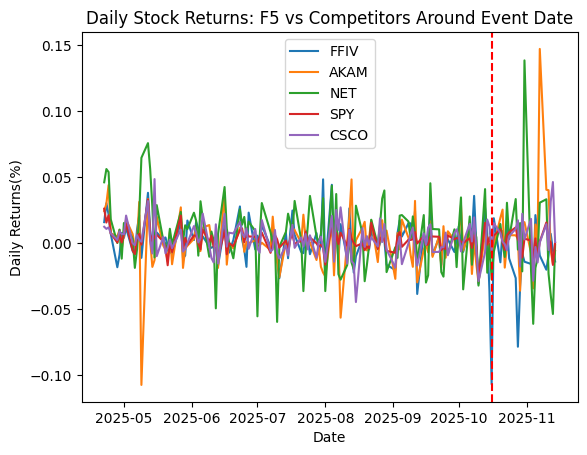

In [132]:
# Plotting the impact of the event
ffiv=prices[prices['ticker'] == 'FFIV']
akam=prices[prices['ticker'] == 'AKAM']
spy=prices[prices['ticker'] == 'SPY']
net=prices[prices['ticker'] == 'NET']
cisco=prices[prices['ticker'] == 'CSCO']

plt.plot(ffiv['date'], ffiv['returns'], label='FFIV')
plt.plot(akam['date'], akam['returns'], label='AKAM')
plt.plot(net['date'],  net['returns'], label='NET')
plt.plot(spy['date'],  spy['returns'], label='SPY')
plt.plot(cisco['date'], cisco['returns'], label='CSCO')
plt.axvline(event_date, color='red', linestyle='--')

plt.title('Daily Stock Returns: F5 vs Competitors Around Event Date')
plt.xlabel('Date')
plt.ylabel('Daily Returns(%)')
plt.legend()
plt.show()


In [103]:
ffiv_after = prices[(prices['ticker'] == 'FFIV') & (prices['date'] >= event_date)]
ffiv_after.head(10)


Price,date,price,ticker,returns
Ticker,,,,
124,2025-10-16,295.350006,FFIV,-0.107029
125,2025-10-17,300.899994,FFIV,0.018791
126,2025-10-20,296.500000,FFIV,-0.014623
127,2025-10-21,299.209991,FFIV,0.009140
128,2025-10-22,297.839996,FFIV,-0.004579
129,2025-10-23,301.859985,FFIV,0.013497
130,2025-10-24,298.339996,FFIV,-0.011661
131,2025-10-27,290.410004,FFIV,-0.026580
132,2025-10-28,267.579987,FFIV,-0.078613


## Methods

### Difference-in-Differences (DiD)
Estimates stock return impact after the breach by comparing:
- FFIV (treated)
- vs competitors (controls)

Formula:
returns ~ treated + post + treated_post

The coefficient on `treated_post` = estimated causal effect.

In [133]:
event_date = pd.to_datetime('2025-10-16')
treated = 'FFIV'

model = run_diff_in_diff(prices, event_date, treated)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     18.33
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           1.76e-11
Time:                        19:09:30   Log-Likelihood:                 2052.5
No. Observations:                 744   AIC:                            -4097.
Df Residuals:                     740   BIC:                            -4078.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0027      0.001      4.316   

## Assumptions

### Parallel Trends Check
Visual check: all companies should move similarly before event.

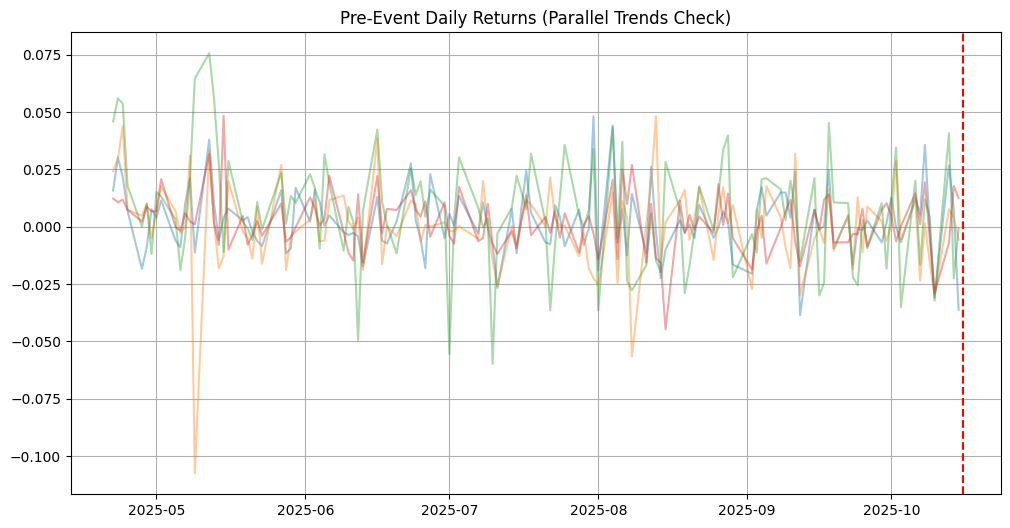

In [126]:
pre_event = prices[prices['date'] < event_date]

plt.figure(figsize=(12,6))

for t in ["FFIV", "AKAM", "NET", "CSCO", "FTNT", "CHKP", "CRWD", "ZS"]:
    se = pre_event[pre_event['ticker']==t]
    plt.plot(se['date'], se['returns'], alpha=0.4)

plt.title("Pre-Event Daily Returns (Parallel Trends Check)")
plt.axvline(event_date, color='red', linestyle='--')
plt.grid(True)
plt.show()


### C. Placebo Test
We fake the event a week earlier to check if there's a false signal.

In [127]:
placebo_date = event_date - pd.Timedelta(days=7)

model_placebo = run_diff_in_diff(prices, placebo_date, "FFIV")
print(model_placebo.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4325
Date:                Fri, 14 Nov 2025   Prob (F-statistic):              0.730
Time:                        18:53:09   Log-Likelihood:                 1980.1
No. Observations:                 714   AIC:                            -3952.
Df Residuals:                     710   BIC:                            -3934.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0029      0.001      4.695   

Results show that in the pre preiod we have no evidence that theres any differnece in trend and so no reason to believe that it would change afterwards.

### D. Trend-Based Robustness Test
Controls for pre-event slope differences.

In [128]:
test_trend_model = difference_in_trends(prices, event_date, "FFIV")
print(test_trend_model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     7.634
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           4.96e-05
Time:                        18:53:09   Log-Likelihood:                 2037.1
No. Observations:                 744   AIC:                            -4066.
Df Residuals:                     740   BIC:                            -4048.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0020      0.001     -1.650

C:\Users\Nick\AppData\Local\Temp\ipykernel_24828\2815444381.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treated'] = np.where(df['ticker'] == treated, 1, 0)
C:\Users\Nick\AppData\Local\Temp\ipykernel_24828\2815444381.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trend'] = (event_date - df['date']).dt.days
C:\Users\Nick\AppData\Local\Temp\ipykernel_24828\2815444381.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde